In [42]:
from src.time_series_prep import *
import pandas as pd
from models.shared_layer import *
from torchviz import make_dot
from torchsummary import summary
from src.data_preprocessing import *
from src.visualizations import *
from src.global_configs import *
from src.time_series_prep import *
import logging

# Initialize logger
logging.basicConfig(
    filename='training.log',  # File where logs will be saved
    level=logging.INFO,  # Set logging level to INFO
    format='%(asctime)s - %(levelname)s - %(message)s',  # Log format
    # filemode='w'  # Overwrite log file on each run
)
logger = logging.getLogger()


In [65]:
df = pd.read_csv("data\\ohio-data\\processed\\cleaned\\2018\\test\\559_testing.csv")
# df['value']
X, y = prepare_time_series_data(df, 'value', window_size, prediction_horizon)

In [69]:
y

array([0.67916435, 0.82853963, 0.94803985, ..., 0.18622593, 0.15635088,
       0.11153829])

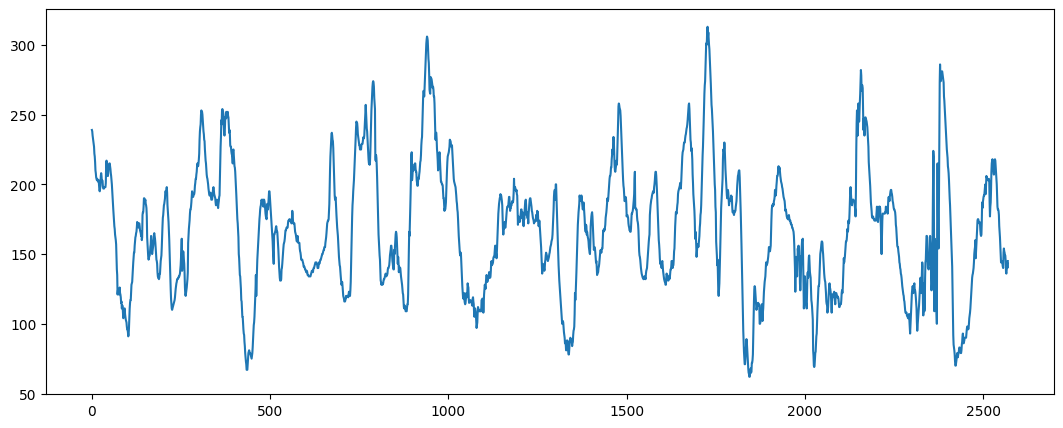

In [61]:
plt.figure(figsize=(13,5))
plt.plot(np.arange(len(df['value'])), df['value'])

In [37]:
scaler = process_all_csv_files(input_folder, output_folder_train, timestamp_col='ts', freq='5min', agg_func='mean')
_, _, _, test_loader, input_shape, input_shape_test, output_shape, output_shape_test =  prepare_data_loader(
                                                                                    window_size,BATCH_SIZE, prediction_horizon = 3,
                                                                                    model_type = 'shared-layer', split_ratio = 0.7, df = None, df_test = None, output_folder_train=output_folder_train, shuffle = False)


Shape of X (features): (12, 13621, 6)
Shape of y (targets): (12, 13621)
Shape of X_test (features): (12, 3942, 6)
Shape of y_test (targets): (12, 3942)


In [38]:
model_all_train_read =  SharedLayerModel(input_shape =input_shape , output_shape=output_shape)
model_all_train_read.load_state_dict(torch.load('saved_models\model_shared-layer_3.pth'))
model_all_train_read.to(device)
model_all_train_read.eval()


C:\Users\menna\AppData\Local\Temp\ipykernel_5640\1995467276.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_all_train_read.load_state_dict(torch.load('saved_models

SharedLayerModel(
  (conv_layers): ModuleList(
    (0-11): 12 x Conv1d(1, 64, kernel_size=(4,), stride=(2,), padding=(1,), dilation=(2,))
  )
  (shared_lstm): GRU(64, 128, batch_first=True)
  (personalized_fc): ModuleList(
    (0-11): 12 x Linear(in_features=128, out_features=64, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (output_layer): Linear(in_features=768, out_features=12, bias=True)
)

In [39]:
def model_prediction(model,test_loader, device, model_type):
    with torch.no_grad():  # Disable gradient calculation for evaluation
        outputs_all_batches = []
        targets_all_batches = []

        for inputs, targets in test_loader:
            # Move data to device (GPU or CPU)
            if model_type == "personalized":
                inputs = [inp.to(device) for inp in inputs]

            elif model_type == "shared-layer" or model_type == "generalized":
                inputs = [inp for inp in inputs]
                inputs = torch.tensor(np.array(inputs)).to(device)

            targets = targets.to(device)
            outputs = model(inputs)
            targets_all_batches.append(targets)
            outputs_all_batches.append(outputs)
    return outputs_all_batches, targets_all_batches
                # print([[outputs[0]]])
                # # # Convert to numpy arrays for masking
                # outputs_np = outputs.cpu().numpy()
                # targets_np = targets.cpu().numpy()
                # abs_patients_errors =  []
                # squared_patients_errors = []
def evaluate_test(model,test_loader, device ,scaler, mask_value, model_type):
    outputs_all_batches, targets_all_batches = model_prediction(model,test_loader, device, model_type)

    if model_type == "personalized":
        abs_patients_errors =  []
        squared_patients_errors = []
        for one_batch in range(len(outputs_all_batches)):
            outputs_np = outputs_all_batches[one_batch].cpu().numpy()
            targets_np = targets_all_batches[one_batch].cpu().numpy()


            for j in range(len(targets_np)):
                    if targets_np[j] != mask_value:
                        sub_output = scaler.inverse_transform([outputs_np[j]])[0][0]
                        sub_target = scaler.inverse_transform([targets_np[j]])[0][0]
                        abs_patients_errors.append(abs(sub_output-sub_target))
                        squared_patients_errors.append((sub_output-sub_target) ** 2)
        mae = np.mean(abs_patients_errors)
        rmse = np.sqrt(np.mean(squared_patients_errors))
        return mae, rmse
    elif model_type == "shared-layer" or model_type == "generalized":
        abs_patients_errors =  {key: [] for key in range(12)}
        squared_patients_errors =  {key: [] for key in range(12)}
        for one_batch in range(len(outputs_all_batches)):
            outputs_np = outputs_all_batches[one_batch].cpu().numpy()
            targets_np = targets_all_batches[one_batch].cpu().numpy()
            for i in range(len(targets_np)): #this prints a list of 12 values of each patient
                for j in range(len(targets_np[i])):
                    if targets_np[i][j] != mask_value:
                        sub_output = scaler.inverse_transform([[outputs_np[i][j]]])[0][0]
                        sub_target = scaler.inverse_transform([[targets_np[i][j]]])[0][0]
                        # print(sub_output)
                        # print(sub_target)
                        abs_patients_errors[j].append(abs(sub_output-sub_target))
                        squared_patients_errors[j].append((sub_output-sub_target) ** 2)
                        # print(abs_patients_errors)
        for patient in range(len(squared_patients_errors)):
            abs_patients_errors[patient] = np.mean(abs_patients_errors[patient])
            squared_patients_errors[patient] = np.sqrt(np.mean(squared_patients_errors[patient]))
        return abs_patients_errors, squared_patients_errors


In [40]:
mae, rmse=  evaluate_test(model_all_train_read,test_loader, device ,scaler, mask_value, 'shared-layer')


In [41]:
np.mean(list(mae.values())), np.mean(list(rmse.values()))

(12.574368378141827, 17.51580865524772)

In [25]:
mae, rmse

(18.7059237318969, 25.53339901369162)

In [ ]:
outputs = torch.cat(outputs, dim=0)
targets = torch.cat(targets, dim=0)
# targets = [[None if val1 == -2.5 else val1 for val1 in sublist1] for sublist1 in targets]
# outputs = [[None if val1 == -2.5 else val2 for val1, val2 in zip(sublist1, sublist2)]
#                  for sublist1, sublist2 in zip(outputs, targets)]

# Create a mask where arr1 equals 0
mask = (targets == -2.5)

# Set elements to None (or np.nan for float compatibility)
targets = np.where(mask, None, targets)
outputs = np.where(mask, None, outputs)


In [ ]:
index = 0
patient1_target = [sublist[index] for sublist in targets]
patient1_output = [ sublist[index]  for sublist in outputs]
plt.figure(figsize=(13,5))
plt.plot(patient1_target)
plt.plot(patient1_output)